In [3]:
import numpy as np

# cache matrix-nullSpaceSolution to avoid recomputation
matrix_nullSpaceSolution = {}

def findNullSpace(A):
    # flatten tupple A
    B=  A.flatten()
    if tuple(B) in matrix_nullSpaceSolution:
        return matrix_nullSpaceSolution[tuple(B)]
    # Compute the SVD of A
    U, S, Vt = np.linalg.svd(A)

    # Find the null space of A
    null_space = Vt.T[:, S.size:]

    # Choose a non-trivial vector from the null space
    non_trivial_solution = null_space[:, 0]
    # Cache the result
    matrix_nullSpaceSolution[tuple(B)] = non_trivial_solution
    return non_trivial_solution
    # return Vt[-1]




def caratheodory(P, w):
    assert len(P) == len(w)
    n, d = P.shape
    if n <= d +1:
        return P, w
    weigtedSumOfPoints = np.dot(w, P)
    # Compute the matrix M (each column is pi - p1)
    M = (P[1:] - P[0]).T  # shape (d, n-1)
    v= findNullSpace(M)   
    v1 = -np.sum(v)
    v = np.insert(v, 0, v1)

    alpha = np.inf
    for i in range(n):
        if v[i] > 0:
            alpha = min(alpha, w[i] / v[i])
    u = w - alpha * v
    assert np.all(u >= -0.0000001)
    S = P[u > 0]
    u = u[u > 0]
    weightedSumOfPoints2 = np.dot(u, S)
    assert np.allclose(weigtedSumOfPoints, weightedSumOfPoints2)
    if len(S) > d + 1:
        return caratheodory(S, u)  # Recursive call if needed
    return S, u


# write the function for k-streaming algorithm based caraheodory algorithm (take d+2 points and keep reducing the points)
import numpy as np

def streaming_caratheodory(P, w, d):

    n = len(P)
    selected_points = P[:d+1]
    selected_weights = w[:d+1]
    
    for i in range(d+1, n):

        selected_points = np.vstack((selected_points, P[i]))
        selected_weights = np.append(selected_weights, w[i])
        
        # Apply Caratheodory's theorem to reduce the set to d+1 points
        selected_points, selected_weights = caratheodory(np.array(selected_points), np.array(selected_weights))
    
    return selected_points, selected_weights

In [4]:
d=3
import tqdm as tqdm
Id=np.eye(d)
# print(I3)
# create A matrix by stacking k copies of I3 with another column of 0s
def A_matrix(k):
    A = np.zeros((d*k, d+1))
    for i in range(k):
        A[d*i:d*(i+1), 0:d] = Id
    return A


# k=10
lambdas={}
d1=[9999999 for i in range(200-2)]
d2=[9999999 for i in range(200-2)]
# log number of regularized points for each value of lambda= c^2/4 for each value of k in a dictionary
noRegularizedPoints={}
# use tqdm to show progress bar
for k in tqdm.tqdm(range(200,2,-1)):
    C=A_matrix(k)

    weigts=np.ones(d*k)

    weigts=weigts/np.sum(weigts)

    #  experiment with different values of c to see how the caratheodory representation changes
    for c in range(1,200):
        # multiply the last 3 rows of B by c

        B=C.copy()
        B[-d:]*=c/2
        # transform B to get the caratheodory representation
        D=transformMatrix(B)
        # remove zero rows
        D=D[:,~np.all(D == 0, axis=0)]
        

        weigtedSum=np.sum(D*weigts[:,None],axis=0)

        S, u = streaming_caratheodory(D, weigts,d=len(D[0]))


        sum_rows=np.sum(S!=1,axis=1)
        lambda1=(c**2)/4
        if (k,lambda1) not in noRegularizedPoints:
            noRegularizedPoints[(k,lambda1)]=[]
        noRegularizedPoints[(k,lambda1)].append(np.sum(sum_rows==d))


        weigtedSum2=np.sum(S*u[:,None],axis=0)

        assert np.allclose(weigtedSum, weigtedSum2)
        if np.sum(sum_rows==d)==1:
            d1[k-3]=min(d1[k-3],(c**2)/4)
        if np.sum(sum_rows==d)==2:
            d2[k-3]=min(d2[k-3],(c**2)/4)
        
        if np.sum(sum_rows==d)==d:
            lambdas[k]=(c**2)/4
            break




 


  0%|          | 0/198 [00:00<?, ?it/s]


NameError: name 'transformMatrix' is not defined

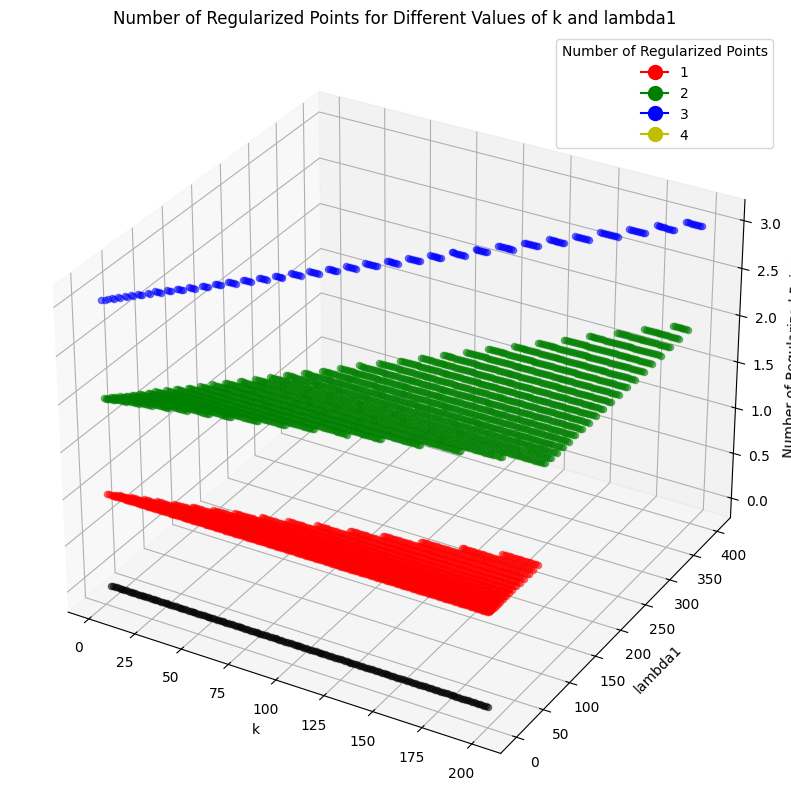

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Convert the noRegularizedPoints dictionary to separate lists
k_values = []
lambda1_values = []
counts = []

for (k, lambda1), count_list in noRegularizedPoints.items():
    k_values.extend([k] * len(count_list))
    lambda1_values.extend([lambda1] * len(count_list))
    counts.extend(count_list)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Define color categories based on the number of regularized points
colors = np.array(['r', 'g', 'b','y'])
categories = [1, 2, 3, 4]
color_map = dict(zip(categories, colors))

# Plot the scatter points with different colors
for count, k, lambda1 in zip(counts, k_values, lambda1_values):
    color = color_map.get(count, 'k')  # Default color is black
    ax.scatter(k, lambda1, count, color=color, alpha=0.5)

# Set labels and title
ax.set_xlabel('k')
ax.set_ylabel('lambda1')
ax.set_zlabel('Number of Regularized Points')
ax.set_title('Number of Regularized Points for Different Values of k and lambda1')

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=f'{category}',
                              markerfacecolor=color, markersize=10) for category, color in color_map.items()]
ax.legend(handles=legend_elements, loc='upper right', title='Number of Regularized Points')

plt.show()

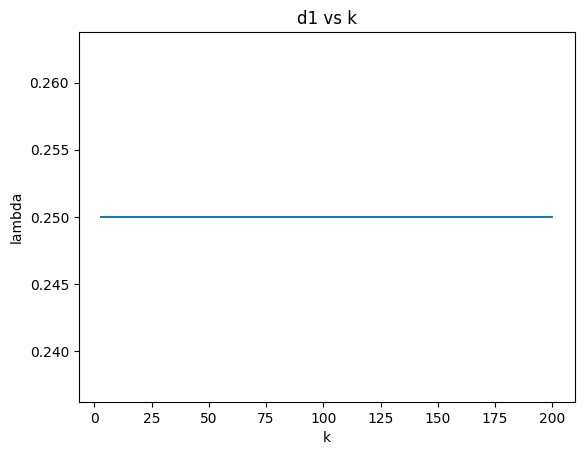

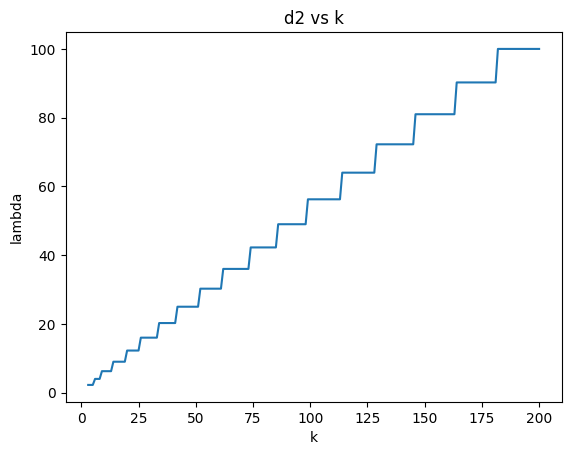

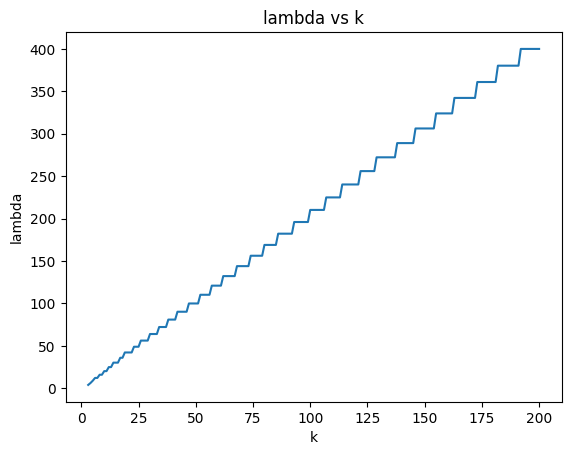

In [58]:
import matplotlib.pyplot as plt

k=list(range(200,2,-1))
plt.plot(k,d1)
plt.xlabel("k")
plt.ylabel("lambda")
plt.title("d1 vs k")

plt.show()
# d2.reverse()
k=list(range(200,2,-1))
plt.plot(k,d2 )
plt.xlabel("k")
plt.ylabel("lambda")
plt.title("d2 vs k")
plt.show()

k=list(lambdas.keys())
v=list(lambdas.values())
plt.plot(k,v)
plt.xlabel("k")
plt.ylabel("lambda")
plt.title("lambda vs k")
plt.show()


# graph d2 and k to see how d2 changes with k
# k=list(range(200,2,-1))
# plt.plot(k,d2)
# plt.xlabel("k")
# plt.ylabel("lambda")

# plt.title("d2 vs k")

# plt.show()



In [53]:

print(noRegularizedPoints)
# plot the first  indexes of  2 in each array vs the dictionary key k
# k=list(noRegularizedPoints.keys())
# v=[x.index(2) for x in noRegularizedPoints.values()]  
# plt.plot(k,v)
# plt.xlabel("k")
# plt.ylabel("index of 2")
# plt.title("index of 2 vs k")

# plt.show()







{(200, 0.25): [1], (200, 1.0): [0], (200, 2.25): [1], (200, 4.0): [1], (200, 6.25): [1], (200, 9.0): [1], (200, 12.25): [1], (200, 16.0): [1], (200, 20.25): [1], (200, 25.0): [1], (200, 30.25): [1], (200, 36.0): [1], (200, 42.25): [1], (200, 49.0): [1], (200, 56.25): [1], (200, 64.0): [1], (200, 72.25): [1], (200, 81.0): [1], (200, 90.25): [1], (200, 100.0): [2], (200, 110.25): [2], (200, 121.0): [2], (200, 132.25): [2], (200, 144.0): [2], (200, 156.25): [2], (200, 169.0): [2], (200, 182.25): [2], (200, 196.0): [2], (200, 210.25): [2], (200, 225.0): [2], (200, 240.25): [2], (200, 256.0): [2], (200, 272.25): [2], (200, 289.0): [2], (200, 306.25): [2], (200, 324.0): [2], (200, 342.25): [2], (200, 361.0): [2], (200, 380.25): [2], (200, 400.0): [3], (199, 0.25): [1], (199, 1.0): [0], (199, 2.25): [1], (199, 4.0): [1], (199, 6.25): [1], (199, 9.0): [1], (199, 12.25): [1], (199, 16.0): [1], (199, 20.25): [1], (199, 25.0): [1], (199, 30.25): [1], (199, 36.0): [1], (199, 42.25): [1], (199, 49.

In [28]:
noRegularizedPoints[34]

[1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3]

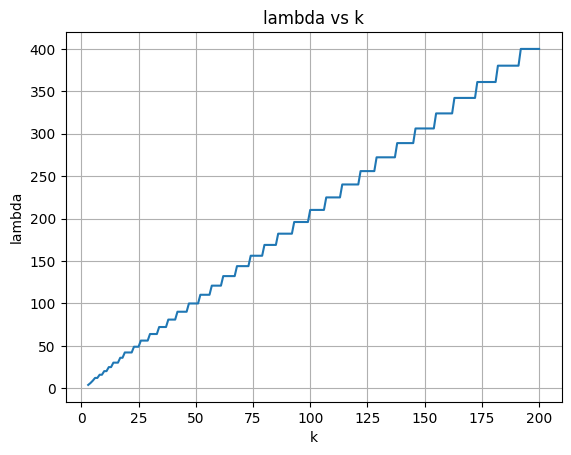

In [32]:
import matplotlib.pyplot as plt
k=[i for i in lambdas.keys()]
l=[lambdas[i] for i in lambdas.keys()]
n=np.array(n)
l=np.array(l)

n_f=5
# smoothed_n=[ n[i:i+n_f].mean() for i in range(0,len(n),n_f)]
# smoothed_l=[ l[i:i+n_f].mean() for i in range(0,len(l),n_f)]
plt.plot(k,l)
plt.grid()

plt.xlabel("k")
plt.ylabel("lambda")
plt.title("lambda vs k")
plt.show()


In [209]:
# save the dictionary to a file
import pickle
with open('lambdas.pkl', 'wb') as f:
    pickle.dump(lambdas, f)

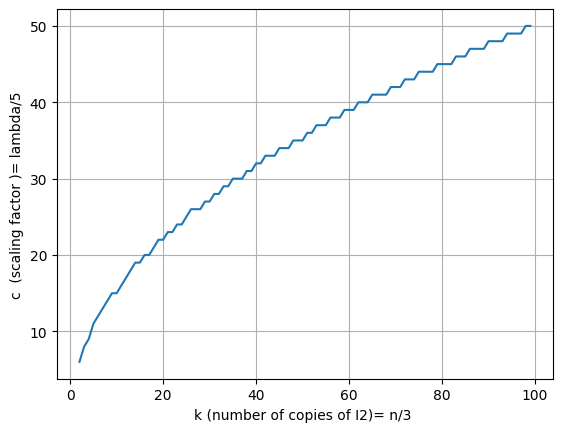

In [203]:
import matplotlib.pyplot as plt
plt.plot(list(k_vs_c.keys()), list(k_vs_c.values()))
plt.xlabel('k (number of copies of I2)= n/3 ')
plt.ylabel('c  (scaling factor )= lambda/5')
plt.grid()
plt.show()



{2: 6, 3: 8, 4: 9, 5: 11, 6: 12, 7: 13, 8: 14, 9: 15, 10: 15, 11: 16, 12: 17, 13: 18, 14: 19, 15: 19, 16: 20, 17: 20, 18: 21, 19: 22, 20: 22, 21: 23, 22: 23, 23: 24, 24: 24, 25: 25, 26: 26, 27: 26, 28: 26, 29: 27, 30: 27, 31: 28, 32: 28, 33: 29, 34: 29, 35: 30, 36: 30, 37: 30, 38: 31, 39: 31, 40: 32, 41: 32, 42: 33, 43: 33, 44: 33, 45: 34, 46: 34, 47: 34, 48: 35, 49: 35, 50: 35, 51: 36, 52: 36, 53: 37, 54: 37, 55: 37, 56: 38, 57: 38, 58: 38, 59: 39, 60: 39, 61: 39, 62: 40, 63: 40, 64: 40, 65: 41, 66: 41, 67: 41, 68: 41, 69: 42, 70: 42, 71: 42, 72: 43, 73: 43, 74: 43, 75: 44, 76: 44, 77: 44, 78: 44, 79: 45, 80: 45, 81: 45, 82: 45, 83: 46, 84: 46, 85: 46, 86: 47, 87: 47, 88: 47, 89: 47, 90: 48, 91: 48, 92: 48, 93: 48, 94: 49, 95: 49, 96: 49, 97: 49, 98: 50, 99: 50}


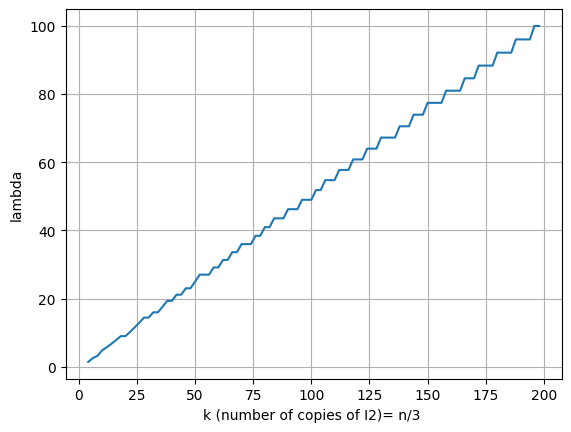

In [205]:
print(k_vs_c)
# I multiplied last digits by c/5 and saved c so root lambda is c/5 ,i.e k_vs_c[c]/5=root(lambda) thus lambda=(k_vs_c[c]/5)^2
lambdas={c:(k_vs_c[c]/5)**2 for c in k_vs_c}
# graph lambdas vs n
lambdas=[lambdas[c] for c in k_vs_c]
# n= 2k
n=[2*k for k in k_vs_c]
plt.plot(n, lambdas)
plt.xlabel('k (number of copies of I2)= n/3 ')
plt.ylabel('lambda')
plt.grid()
plt.show()


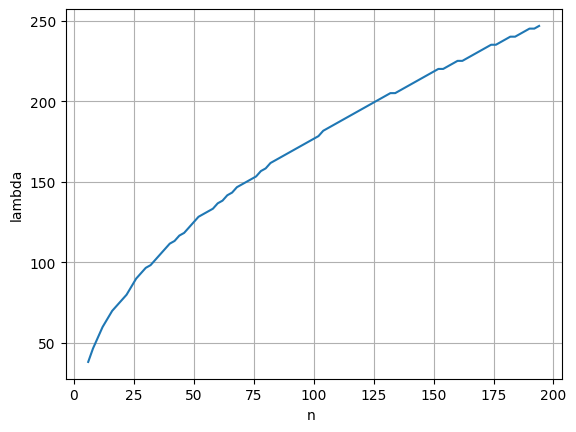

In [202]:
# import matplotlib.pyplot as plt
# plt.plot(list(k_vs_c.keys()), list(k_vs_c.values()))
# plt.xlabel('k (number of copies of I3) n/3 ')
# plt.ylabel('c  (scaling factor =lambda/5)')

# plt.grid()
# plt.show()


# graph n vs lambda
n=[2*k for k in k_vs_c.keys()]
lambda_values=[5*c for c in k_vs_c.values()]
# smoothen the values
smoothingFactor=3
lambda_values=[np.mean(lambda_values[i:i+smoothingFactor]) for i in range(len(lambda_values)-smoothingFactor)]
n=[np.mean(n[i:i+smoothingFactor]) for i in range(len(n)-smoothingFactor)]


plt.plot(n, lambda_values)
plt.xlabel('n ')
plt.ylabel('lambda')
# smoothen the graph

plt.grid()
plt.show()


In [193]:
# last example of the caratheodory representation
# print(D)
# print(weigts)
print("Sum of weights",np.sum(weigts))
print("weigtedSum of D =",np.sum(D*weigts[:,None],axis=0))    
S, u = caratheodory(D, weigts)
print("Sum of weights of D",np.sum(u))   
weigtedSum=("weigtedSum of S = ",np.sum(S*u[:,None],axis=0))

print(S)
print(*weigtedSum)
print("Sum of weights",np.sum(u))


Sum of weights 1.0
weigtedSum of D = [1. 1.]
Sum of weights of D 1.0000000000000007
[[  1.   0.]
 [100.   0.]
 [  0. 100.]]
weigtedSum of S =  [1. 1.]
Sum of weights 1.0000000000000007
